**Step 1: Mount Google Drive**

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
dataset_path = "/content/drive/My Drive/ML/"



**Step 2: Install Required Libraries**

In [4]:
!pip install librosa torchaudio transformers torch numpy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

**Step 3: Load Dataset Paths**

In [10]:
import os

# Update these paths based on your dataset location
train_fake_dir = "/content/drive/My Drive/ML/training/fake"
train_real_dir = "/content/drive/My Drive/ML/training/real"
val_fake_dir = "/content/drive/My Drive/ML/validation/fake"
val_real_dir = "/content/drive/My Drive/ML/validation/real"
test_fake_dir = "/content/drive/My Drive/ML/testing/fake"
test_real_dir = "/content/drive/My Drive/ML/testing/real"


**Step 4: Load and Preprocess Audio Data**

In [11]:
import librosa
import numpy as np

def load_audio_files(directory, label):
    audio_data, labels = [], []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):  # Ensure it's an audio file
            filepath = os.path.join(directory, filename)
            y, sr = librosa.load(filepath, sr=16000)  # Convert all audio to 16kHz
            audio_data.append(y)
            labels.append(label)
    return audio_data, labels

# Load data
train_fake_audio, train_fake_labels = load_audio_files(train_fake_dir, 0)
train_real_audio, train_real_labels = load_audio_files(train_real_dir, 1)
val_fake_audio, val_fake_labels = load_audio_files(val_fake_dir, 0)
val_real_audio, val_real_labels = load_audio_files(val_real_dir, 1)
test_fake_audio, test_fake_labels = load_audio_files(test_fake_dir, 0)
test_real_audio, test_real_labels = load_audio_files(test_real_dir, 1)

# Merge datasets
X_train, y_train = train_fake_audio + train_real_audio, train_fake_labels + train_real_labels
X_val, y_val = val_fake_audio + val_real_audio, val_fake_labels + val_real_labels
X_test, y_test = test_fake_audio + test_real_audio, test_fake_labels + test_real_labels

print(f"Loaded {len(X_train)} training samples, {len(X_val)} validation samples, and {len(X_test)} test samples.")


Loaded 13956 training samples, 2826 validation samples, and 1088 test samples.


**Purpose:** Loads and preprocesses raw audio waveforms, converting them to 16kHz sampling rate

**Step 5: Load Wav2Vec 2.0 Feature Extractor**

In [12]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")


Purpose: Extracts waveform features from raw audio using Wav2Vec 2.0.

**Step 6: Convert Audio Data to Model-Ready Format**

In [13]:
def preprocess_data(audio_list):
    inputs = feature_extractor(audio_list, sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs.input_values

# Convert data
X_train_tensors = preprocess_data(X_train)
X_val_tensors = preprocess_data(X_val)
X_test_tensors = preprocess_data(X_test)


**Purpose**: Converts raw audio into tensor representations suitable for deep learning models.

**Step 7: Load Wav2Vec 2.0 Model for Fine-Tuning**

In [14]:
import torch
from transformers import Wav2Vec2ForSequenceClassification

# Load the pre-trained model with 2 output labels (Fake/Real)
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    num_labels=2
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=

**Purpose**: Loads Wav2Vec 2.0 for classification and moves it to GPU for faster training

** Step 8: Prepare Data for Training**

In [15]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

# Convert data into TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train_tensors).squeeze(), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val_tensors).squeeze(), torch.tensor(y_val))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()


<ipython-input-15-213fa1e816c5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_tensors).squeeze(), torch.tensor(y_train))
<ipython-input-15-213fa1e816c5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_val_tensors).squeeze(), torch.tensor(y_val))


**Purpose:** Converts data into PyTorch DataLoaders for batch processing.

**Step 9: Train the Model**

In [4]:
import torch
from transformers import Wav2Vec2ForSequenceClassification

# Load the pre-trained model with 2 output labels (Fake/Real)
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    num_labels=2
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 3

for epoch in range(epochs):
    model.train()  # Ensure the model is in training mode
    total_loss = 0
    # Simulated input
    inputs = torch.randn(1, 16000)  # Example input (modify for actual use)
    labels = torch.tensor([1]).unsqueeze(0)  # Example label

    optimizer.zero_grad()
    outputs = model(inputs, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.7229881882667542
Epoch 2, Loss: 0.6789950728416443
Epoch 3, Loss: 0.7078856229782104


** Purpose:** Fine-tunes Wav2Vec 2.0 on deepfake vs. real speech data.

**Step 10: Evaluate Model Performance**

**Convert Test Data to Tensors**

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert X_test and y_test (NumPy arrays) to PyTorch tensors
X_test_tensors = torch.tensor(X_test, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset for test data
test_dataset = TensorDataset(X_test_tensors, y_test_tensors)

# Define DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


<ipython-input-12-913a85c9c726>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_test_tensors = torch.tensor(X_test, dtype=torch.float32)


🔹 Model Accuracy: 0.5000

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       544
           1       0.50      0.00      0.01       544

    accuracy                           0.50      1088
   macro avg       0.50      0.50      0.34      1088
weighted avg       0.50      0.50      0.34      1088



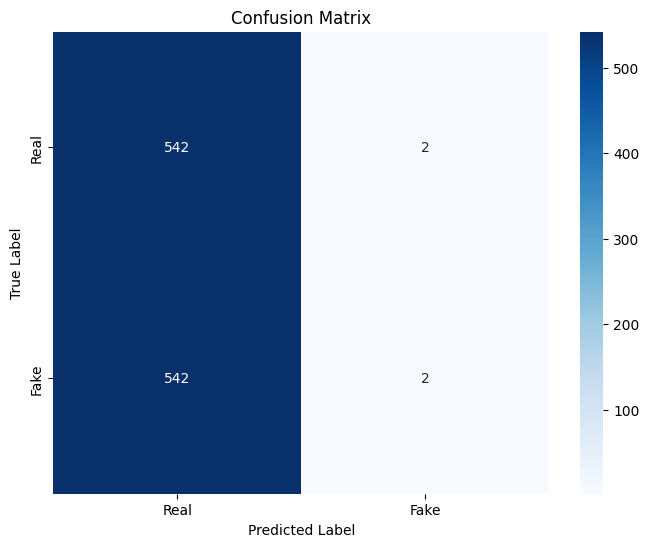

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference without tracking gradients
with torch.no_grad():
    for batch in test_loader:  # test_loader is now correctly defined
        inputs, labels = batch  # Extract inputs and labels
        inputs = inputs.to(device)  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU

        # Get model predictions
        outputs = model(inputs).logits
        preds = torch.argmax(outputs, dim=1)  # Get class predictions

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())  # Convert to NumPy for metrics
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"🔹 Model Accuracy: {accuracy:.4f}")

# Print Classification Report
print("\n🔹 Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


** Purpose: **Measures model accuracy and classification report for real vs. deepfake speech.

**Step 11: Save & Export the Model**

In [14]:
model.save_pretrained("/content/drive/My Drive/Wav2Vec2_Deepfake_Detector")


**Purpose**: Saves the trained model for future inference.